
# Feature transformations with ensembles of trees

Transform your features into a higher dimensional, sparse space. Then train a
linear model on these features.

First fit an ensemble of trees (totally random trees, a random forest, or
gradient boosted trees) on the training set. Then each leaf of each tree in the
ensemble is assigned a fixed arbitrary feature index in a new feature space.
These leaf indices are then encoded in a one-hot fashion.

Each sample goes through the decisions of each tree of the ensemble and ends up
in one leaf per tree. The sample is encoded by setting feature values for these
leaves to 1 and the other feature values to 0.

The resulting transformer has then learned a supervised, sparse,
high-dimensional categorical embedding of the data.


In [2]:
%matplotlib inline

from sklearn import set_config
set_config(display='diagram')

First, we will create a large dataset and split it into three sets:

- a set to train the ensemble methods which are later used to as a feature
  engineering transformer;
- a set to train the linear model;
- a set to test the linear model.

It is important to split the data in such way to avoid overfitting by leaking
data.



In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=80000, random_state=10)

X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10)
X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = \
    train_test_split(X_full_train, y_full_train, test_size=0.5,
                     random_state=10)

For each of the ensemble methods, we will use 10 estimators and a maximum
depth of 3 levels.



In [4]:
n_estimators = 10
max_depth = 3

First, we will start by training the random forest and gradient boosting on
the separated training set



In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

random_forest = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10)
random_forest.fit(X_train_ensemble, y_train_ensemble)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10)
_ = gradient_boosting.fit(X_train_ensemble, y_train_ensemble)

The :class:`~sklearn.ensemble.RandomTreesEmbedding` is an unsupervised method
and thus does not required to be trained independently.



In [6]:
from sklearn.ensemble import RandomTreesEmbedding

random_tree_embedding = RandomTreesEmbedding(
    n_estimators=n_estimators, max_depth=max_depth, random_state=0)

Now, we will create three pipelines that will use the above embedding as
a preprocessing stage.

The random trees embedding can be directly pipelined with the logistic
regression because it is a standard scikit-learn transformer.



In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

rt_model = make_pipeline(
    random_tree_embedding, LogisticRegression(max_iter=1000))
rt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('randomtreesembedding',
                 RandomTreesEmbedding(max_depth=3, n_estimators=10,
                                      random_state=0)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Then, we can pipeline random forest or gradient boosting with a logistic
regression. However, the feature transformation will happen by calling the
method `apply`. The pipeline in scikit-learn expects a call to `transform`.
Therefore, we wrapped the call to `apply` within a `FunctionTransformer`.



In [8]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder


def rf_apply(X, model):
    return model.apply(X)


rf_leaves_yielder = FunctionTransformer(
    rf_apply, kw_args={"model": random_forest})

rf_model = make_pipeline(
    rf_leaves_yielder, OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000))
rf_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function rf_apply at 0x7fa37866a1e0>,
                                     kw_args={'model': RandomForestClassifier(max_depth=3,
                                                                              n_estimators=10,
                                                                              random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [9]:
def gbdt_apply(X, model):
    return model.apply(X)[:, :, 0]


gbdt_leaves_yielder = FunctionTransformer(
    gbdt_apply, kw_args={"model": gradient_boosting})

gbdt_model = make_pipeline(
    gbdt_leaves_yielder, OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000))
gbdt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function gbdt_apply at 0x7fa37866a400>,
                                     kw_args={'model': GradientBoostingClassifier(n_estimators=10,
                                                                                  random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

We can finally show the different ROC curves for all the models.



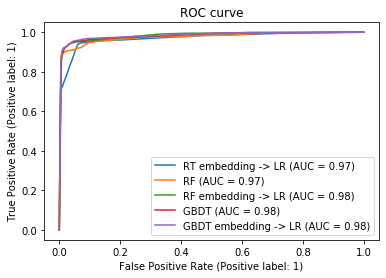

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots()

models = [
    ("RT embedding -> LR", rt_model),
    ("RF", random_forest),
    ("RF embedding -> LR", rf_model),
    ("GBDT", gradient_boosting),
    ("GBDT embedding -> LR", gbdt_model),
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = plot_roc_curve(
        pipeline, X_test, y_test, ax=ax, name=name)
_ = ax.set_title('ROC curve')

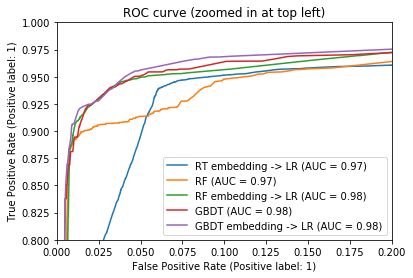

In [11]:
fig, ax = plt.subplots()
for name, pipeline in models:
    model_displays[name].plot(ax=ax)

ax.set_xlim(0, 0.2)
ax.set_ylim(0.8, 1)
_ = ax.set_title('ROC curve (zoomed in at top left)')